<a href="https://colab.research.google.com/github/componavt/differential_equations/blob/main/src/hill_equation/deepxde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Neural Network Solution for ODE with Hill-Type Nonlinearity
**Goal**: Numerically solve an ODE with a Hill-type nonlinearity using DeepXDE.

- **Equation**: `dx/dt = x^(1/\u03b1) / (b^(1/\u03b1) + x^(1/\u03b1))`
- **Context**:
  - This is not the classical Hill equation but contains a Hill-type function.
  - This form appears in simplified gene regulation models.
- **Conditions**:
  - $ \alpha \to 0 $ (small, stiff regime)
  - $ x(0) \approx b $ (initial condition close to $b$)
- **Method**:
  - Physics-Informed Neural Network (PINN) with a 4-layer FNN (tanh activations).
  - Adam optimizer (LR=0.001).
- **Output**: Predicted `x(t)` compared with an approximate analytical solution.

In [7]:
# Parameters
alpha = 0.01
b = 1.0
x0 = b * 0.99999  # Начальное условие x(0) ≈ b

!pip install deepxde
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Compiling model...
Building feed-forward neural network...
'build' took 0.090776 s

'compile' took 1.844591 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.23e-01, 1.00e+00]    [1.23e-01, 1.00e+00]    []  
100       [7.85e-03, 3.90e-03]    [7.89e-03, 3.90e-03]    []  
200       [5.57e-04, 1.55e-03]    [5.59e-04, 1.55e-03]    []  
300       [4.41e-04, 1.49e-03]    [4.43e-04, 1.49e-03]    []  
400       [3.82e-04, 1.44e-03]    [3.84e-04, 1.44e-03]    []  
500       [3.71e-04, 1.41e-03]    [3.73e-04, 1.41e-03]    []  
600       [3.74e-04, 1.39e-03]    [3.76e-04, 1.39e-03]    []  
700       [3.73e-04, 1.38e-03]    [3.75e-04, 1.38e-03]    []  
800       [3.69e-04, 1.38e-03]    [3.71e-04, 1.38e-03]    []  
900       [3.65e-04, 1.38e-03]    [3.66e-04, 1.38e-03]    []  
1000      [3.61e-04, 1.38e-03]    [3.62e-04, 1.38e-03]    []  
1100      [3.57e-04, 1.38e-03]    [3.58e-04, 1.38e-03]    []  
1200      [3.54e-04, 1.38e-03]    [3.55e-04,

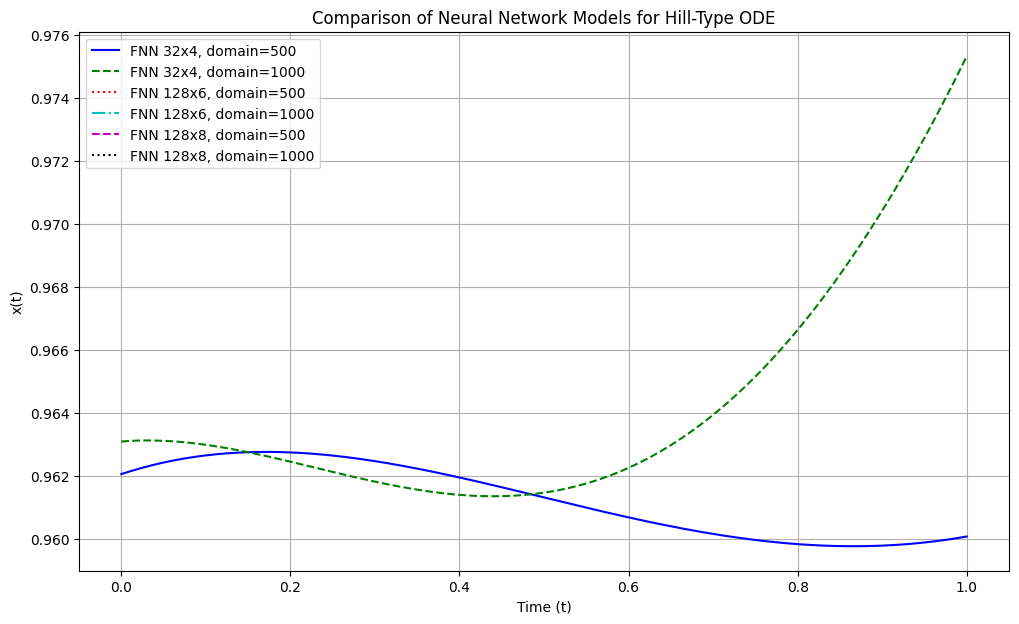

In [11]:
# Solution of ODE with Hill-like RHS: model comparison and approximation

# ODE with Hill-like RHS
def hill_type_ode(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=0)
    x_alpha = tf.pow(y, 1 / alpha)
    b_alpha = tf.pow(b, 1 / alpha)
    return dy_t - x_alpha / (b_alpha + x_alpha)

# Time domain geometry
geom = dde.geometry.TimeDomain(0, 1)

# Initial condition: x(0) ≈ b
ic = dde.icbc.IC(geom, lambda x: x0, lambda _, on_initial: on_initial)

# Configurations to compare
configs = [
    (500, [1] + [32] * 4 + [1], "FNN 32x4, domain=500"),
    (1000, [1] + [32] * 4 + [1], "FNN 32x4, domain=1000"),
    (500, [1] + [128] * 6 + [1], "FNN 128x6, domain=500"),
    (1000, [1] + [128] * 6 + [1], "FNN 128x6, domain=1000"),
    (500, [1] + [128] * 8 + [1], "FNN 128x8, domain=500"),
    (1000, [1] + [128] * 8 + [1], "FNN 128x8, domain=1000")
]

# Prepare test time points
t_test = np.linspace(0, 1, 500).reshape(-1, 1)

# Plot all models
plt.figure(figsize=(12, 7))

styles = ['-', '--', ':', '-.', 'dashed', 'dotted']  # Исправлено: убрано '.'
colors = ['b', 'g', 'r', 'c', 'm', 'k']  # Добавлены разные цвета для надежности

for i, (num_domain, architecture, label) in enumerate(configs):
    data = dde.data.PDE(
        geom,
        hill_type_ode,
        ic,
        num_domain=num_domain,
        num_boundary=4,
        num_test=500
    )

    net = dde.nn.FNN(architecture, "tanh", "Glorot normal")

    model = dde.Model(data, net)
    model.compile("adam", lr=0.001)
    model.train(iterations=3000, display_every=100)

    x_pred = model.predict(t_test)
    plt.plot(t_test, x_pred,
             linestyle=styles[i],
             color=colors[i],
             label=label)

#plt.ylim(-0.1, 2.0)  # y 0.962, 0.974
#plt.xlim(0, 1.5)     # x 0, 1

# Выведите предсказания для всех моделей в консоль:
for num_domain, architecture, label in configs:
    x_pred = model.predict(t_test)
    print(f"Model {label}: min={np.min(x_pred):.2f}, max={np.max(x_pred):.2f}")

# Finalize plot for model comparison
plt.xlabel("Time (t)")
plt.ylabel("x(t)")
plt.title("Comparison of Neural Network Models for Hill-Type ODE")
plt.legend()
plt.grid(True)
plt.show()

Compiling model...
Building feed-forward neural network...
'build' took 0.100803 s

'compile' took 2.193461 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.23e-01, 1.00e+00]    [1.23e-01, 1.00e+00]    []  
100       [5.22e-04, 1.65e-03]    [5.21e-04, 1.65e-03]    []  
200       [4.06e-04, 1.43e-03]    [4.07e-04, 1.43e-03]    []  
300       [4.07e-04, 1.39e-03]    [4.09e-04, 1.39e-03]    []  
400       [3.95e-04, 1.39e-03]    [3.96e-04, 1.39e-03]    []  
500       [3.84e-04, 1.39e-03]    [3.85e-04, 1.39e-03]    []  
600       [3.90e-04, 1.37e-03]    [3.91e-04, 1.37e-03]    []  
700       [3.95e-04, 1.37e-03]    [3.96e-04, 1.37e-03]    []  
800       [3.95e-04, 1.36e-03]    [3.96e-04, 1.36e-03]    []  
900       [1.08e-02, 2.82e-02]    [1.08e-02, 2.82e-02]    []  
1000      [5.10e-04, 1.61e-03]    [5.12e-04, 1.61e-03]    []  
1100      [3.94e-04, 1.50e-03]    [3.96e-04, 1.50e-03]    []  
1200      [3.80e-04, 1.49e-03]    [3.82e-04,

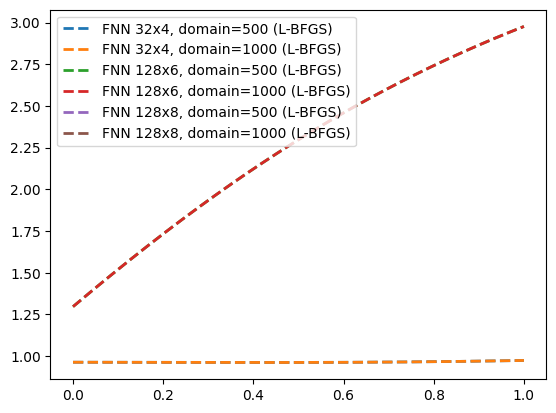

In [9]:
# --- L-BFGS Fine-Tuning (after Adam) ---
# Note: Run this AFTER initial training with Adam
# Purpose: Further refine the solution for better accuracy

for num_domain, architecture, label in configs:
    # Re-initialize model (optional, but ensures clean state)
    net = dde.nn.FNN(architecture, "tanh", "Glorot normal")
    model = dde.Model(data, net)

    # Step 1: Train with Adam first
    model.compile("adam", lr=0.001)
    model.train(iterations=3000, display_every=100)

    # Step 2: Switch to L-BFGS for fine-tuning
    model.compile("L-BFGS")  # No learning rate needed
    model.train(iterations=1000)  # Usually needs fewer iterations

    # Optional: Plot the L-BFGS refined solution
    x_pred_lbfgs = model.predict(t_test)
    plt.plot(t_test, x_pred_lbfgs, '--', linewidth=2, label=f"{label} (L-BFGS)")

plt.legend()
plt.show()

# ⚡ Approximate Solution with Heaviside Step Function  
This code solves the same ODE using an explicit Heaviside step-function approximation for the limit case when $\alpha \to 0$.  
It gives a simple, interpretable solution used for comparison with neural network predictions.  


In [10]:
# Approximate solution using improved Heaviside step-like logic
# For small alpha, the function behaves like a steep sigmoid
x_heaviside = b * (1 - np.exp(-100 * t))

plt.figure(figsize=(10, 5))
plt.plot(t, x_heaviside, 'k--', label='Heaviside-like Approximation')
plt.ylim([0, b + 0.1])
plt.xlabel("Time (t)")
plt.ylabel("x(t)")
plt.title("Steep Step-like Approximate Solution for α → 0")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 't' is not defined

In [ ]:
# Fourier approximation using another method (e.g., SciPy solve_ivp)
from scipy.integrate import solve_ivp

# Define the RHS of the ODE for SciPy
def rhs(t, x):
    x_alpha = x ** (1 / alpha)
    b_alpha = b ** (1 / alpha)
    return x_alpha / (b_alpha + x_alpha)

# Solve the ODE numerically
sol = solve_ivp(rhs, [0, 3], [x0], t_eval=t.flatten(), method='RK45')

plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[0], 'g-', label='SciPy RK45 Solution')
plt.xlabel("Time (t)")
plt.ylabel("x(t)")
plt.title("Numerical Solution of Hill-Type ODE via SciPy")
plt.legend()
plt.grid(True)
plt.show()